<a href="https://colab.research.google.com/github/BunnyNoBugs/tiktok-analysis/blob/main/notebooks/tiktok_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sktime[all_extras]
!pip install prophet
!pip install orbit-ml
!pip install TikTokApi
!python -m playwright install

!sudo apt-get install libbrotli1\
    libnotify4\
    libwoff1\
    gstreamer1.0-plugins-base\
    libgstreamer1.0-0\
    libgstreamer-gl1.0-0\
    gstreamer1.0-plugins-bad\
    libenchant1c2a\
    libsecret-1-0\
    libhyphen0

ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68
  Using cached https://files.pythonhosted.org/packages/08/b9/b4f0938b38dbe775c4def707f525ab816b9d0215ecd8ab2d76780f4514f8/cmdstanpy-0.9.68-py3-none-any.whl
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant1c2a is already the newest version (1.6.0-11.1).
libhyphen0 is already the newest version (2.8.8-5).
libnotify4 is already the newest version (0.7.7-3).
libsecret-1-0 is already the newest version (0.18.6-1).
gstreamer1.0-plugins-base is already the newes

In [ ]:
import pandas as pd
from prophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_error
from orbit.diagnostics.plot import plot_predicted_data
from TikTokApi import TikTokApi

In [ ]:
'''
from TikTokApi import TikTokApi
import json
import os

api = TikTokApi.get_instance()

hashtag = 'popit'
count = 1800

print(f'hashtag: #{hashtag}')
tiktoks = api.by_hashtag(hashtag, count=count)

print('download successful!')

if not os.path.exists('data'):
    os.mkdir('data')

with open('data/tiktoks_hashtag.json', 'w') as f:
    json.dump(tiktoks, f)

print('tiktoks saved!')
'''

"\nfrom TikTokApi import TikTokApi\nimport json\nimport os\n\napi = TikTokApi.get_instance()\n\nhashtag = 'popit'\ncount = 1800\n\nprint(f'hashtag: #{hashtag}')\ntiktoks = api.by_hashtag(hashtag, count=count)\n\nprint('download successful!')\n\nif not os.path.exists('data'):\n    os.mkdir('data')\n\nwith open('data/tiktoks_hashtag.json', 'w') as f:\n    json.dump(tiktoks, f)\n\nprint('tiktoks saved!')\n"

In [ ]:
!python '/content/drive/MyDrive/Colab Notebooks/tiktok_analysis/tiktoks_download.py'

hashtag: #ghosthoney
download successful!
tiktoks saved!


In [ ]:
tt_df = pd.read_json('/content/data/tiktoks_hashtag.json')
tt_df['createTime'] = pd.to_datetime(tt_df['createTime'], unit='s').dt.date
# tt_df = tt_df[tt_df['createTime'] >= pd.to_datetime('2021')]
tt_df['likes'] = tt_df['stats'].apply(lambda x: x['diggCount'])
tt_df['shares'] = tt_df['stats'].apply(lambda x: x['shareCount'])
tt_df['comments'] = tt_df['stats'].apply(lambda x: x['commentCount'])
tt_df['plays'] = tt_df['stats'].apply(lambda x: x['playCount'])

In [ ]:
tt_df

,id,desc,createTime,video,author,music,challenges,stats,duetInfo,originalItem,officalItem,textExtra,secret,forFriend,digged,itemCommentStatus,showNotPass,vl1,itemMute,authorStats,privateItem,duetEnabled,stitchEnabled,shareEnabled,isAd,stickersOnItem,effectStickers,warnInfo,likes,shares,comments,plays
0,6977519571653774336,#ad excited to make this painting for Jiahao &...,2021-06-25,"{'id': '6977519571653774597', 'height': 1024, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6850111632043935745', 'title': 'Lofi n...","[{'id': '20898', 'title': 'ad', 'desc': '', 'p...","{'diggCount': 50800, 'shareCount': 473, 'comme...",{'duetFromId': '0'},False,False,"[{'awemeId': '', 'start': 77, 'end': 95, 'hash...",False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,False,False,True,False,NaN,NaN,NaN,50800,473,642,161800
1,6977123858335714304,Answer to @brennabeanlf existential dread✨,2021-06-23,"{'id': '6977123858335714565', 'height': 1024, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6817665487665629186', 'title': 'Chopin...",NaN,"{'diggCount': 150500, 'shareCount': 14600, 'co...",{'duetFromId': '0'},False,False,"[{'awemeId': '', 'start': 10, 'end': 23, 'hash...",False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,False,False,True,False,NaN,NaN,NaN,150500,14600,4185,581600
2,6975316622785432576,Answer to @ereauele libras love to play,2021-06-19,"{'id': '6975316622785432838', 'height': 1024, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6777279827805390850', 'title': 'Storie...",NaN,"{'diggCount': 115000, 'shareCount': 3769, 'com...",{'duetFromId': '0'},False,False,"[{'awemeId': '', 'start': 10, 'end': 19, 'hash...",False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,False,False,True,False,NaN,NaN,NaN,115000,3769,3601,423800
3,6974907371772480512,the ghosthoney sandwich,2021-06-17,"{'id': '6974907371772480773', 'height': 1024, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6974907259268713221', 'title': 'origin...",NaN,"{'diggCount': 185600, 'shareCount': 4235, 'com...",{'duetFromId': '0'},False,False,NaN,False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,False,False,True,False,NaN,NaN,NaN,185600,4235,1805,676600
4,6972693902243449856,I’m honored to be able to partner with @itgets...,2021-06-12,"{'id': '6972693902243450117', 'height': 1024, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6773844337747822594', 'title': 'LE BAL...","[{'id': '1668529204085765', 'title': 'creativi...","{'diggCount': 54000, 'shareCount': 439, 'comme...",{'duetFromId': '0'},False,False,"[{'awemeId': '', 'start': 39, 'end': 52, 'hash...",False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,False,False,True,False,NaN,NaN,NaN,54000,439,965,328200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,6684028773500718080,important delivery #foryou #wholesometiktok #f...,2019-04-26,"{'id': '6684028773500718341', 'height': 1280, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '6683368159635852038', 'title': 'origin...","[{'id': '42164', 'title': 'foryou', 'desc': ''...","{'diggCount': 2423, 'shareCount': 26, 'comment...",{'duetFromId': '0'},False,False,"[{'awemeId': '', 'start': 19, 'end': 26, 'hash...",False,False,False,0,False,False,False,"{'followingCount': 317, 'followerCount': 25000...",False,True,True,True,False,NaN,NaN,NaN,2423,26,13,37400
466,6681783516226653184,#jkrowling has been sitting on this for 20 yea...,2019-04-20,"{'id': '6681783516226653446', 'height': 1280, ...","{'id': '6674310597444600837', 'uniqueId': 'gho...","{'id': '222450083194306560', 'title': 'Harry P...","[{'id': '289985', 'title': 'jkrowling', 'desc'...","{'diggCount': 5772, 'shareC

In [ ]:
likes_df = pd.DataFrame(tt_df.groupby('createTime')['likes'].mean())
likes_df['count'] = tt_df.groupby('createTime').size().to_numpy()
likes_df['shares'] = tt_df.groupby('createTime')['shares'].mean()
likes_df['comments'] = tt_df.groupby('createTime')['comments'].mean()
likes_df['plays'] = tt_df.groupby('createTime')['plays'].mean()
likes_df = likes_df.reset_index()
likes_df = likes_df.rename(columns={'createTime': 'ds', 'likes': 'y'})

train_df, test_df = temporal_train_test_split(likes_df)

In [ ]:
test_df

,ds,y,count,shares,comments,plays
315,2020-10-29,91800.0,1,1421.0,1673.0,445200.0
316,2020-10-31,463500.0,1,10200.0,2049.0,1500000.0
317,2020-11-01,232400.0,1,2514.0,1096.0,1100000.0
318,2020-11-03,107800.0,1,5520.0,723.0,526000.0
319,2020-11-04,99200.0,1,3702.0,1150.0,507500.0
...,...,...,...,...,...,...
415,2021-06-12,54100.0,1,439.0,965.0,328600.0
416,2021-06-17,185800.0,1,4236.0,1806.0,677200.0
417,2021-06-19,115200.0,1,3780.0,3605.0,424600.0
418,2021-06-23,152600.0,1,14900.0,4252.0,589800.0


In [ ]:
pd.Series(pd.date_range(start='2021-06-25', periods=100))

0    2021-06-25
1    2021-06-26
2    2021-06-27
3    2021-06-28
4    2021-06-29
        ...    
95   2021-09-28
96   2021-09-29
97   2021-09-30
98   2021-10-01
99   2021-10-02
Length: 100, dtype: datetime64[ns]

In [ ]:
comments_df = likes_df.copy()
comments_df = comments_df.rename(columns={'y': 'likes', 'comments': 'y'})
train_df, test_df = temporal_train_test_split(comments_df)

In [ ]:
shares_df = likes_df.copy()
shares_df = shares_df.rename(columns={'y': 'likes', 'shares': 'y'})
train_df, test_df = temporal_train_test_split(shares_df)

In [ ]:
plays_df = likes_df.copy()
plays_df = plays_df.rename(columns={'y': 'likes', 'plays': 'y'})
train_df, test_df = temporal_train_test_split(plays_df)

<AxesSubplot:>

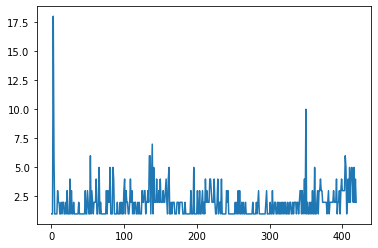

In [ ]:
# разница между тиктоками в днях
delta = likes_df['ds'] - likes_df.shift()['ds']
delta.dt.days.plot()

In [ ]:
%%time

model = Prophet()
# model.add_regressor('count')
# model.add_regressor('comments')
# model.add_regressor('plays')
# model.add_regressor('shares')
model.fit(train_df)
pred = model.predict(test_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.3 s, sys: 69.8 ms, total: 2.37 s
Wall time: 2.38 s


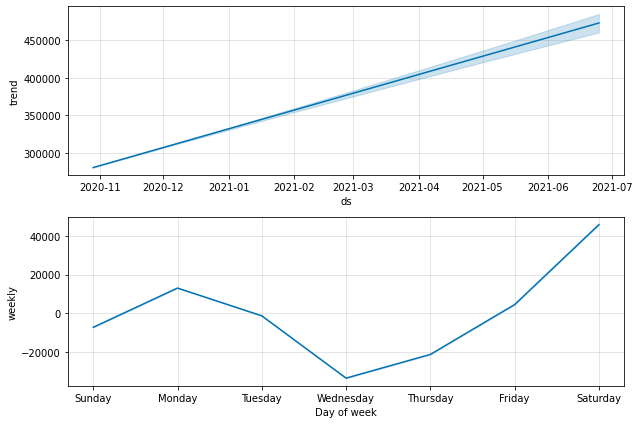

In [ ]:
model.plot_components(pred);

In [ ]:
pred = pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
pred = pred.rename(columns={'yhat': 'prediction', 'yhat_lower': 'prediction_5', 'yhat_upper': 'prediction_95'})

In [ ]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-29,280471.992221,27693.482710,501383.791540,280471.992221,280471.992221,-21259.619586,-21259.619586,-21259.619586,-21259.619586,-21259.619586,-21259.619586,0.0,0.0,0.0,259212.372635
1,2020-10-31,282082.659970,87650.543966,563508.152815,282082.659970,282082.659970,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,0.0,0.0,0.0,327860.885759
2,2020-11-01,282887.993845,55188.531150,521118.277637,282887.993845,282887.993845,-7243.502690,-7243.502690,-7243.502690,-7243.502690,-7243.502690,-7243.502690,0.0,0.0,0.0,275644.491154
3,2020-11-03,284498.661594,41185.584467,512685.754037,284495.489803,284499.177226,-1306.193473,-1306.193473,-1306.193473,-1306.193473,-1306.193473,-1306.193473,0.0,0.0,0.0,283192.468121
4,2020-11-04,285303.995469,30134.112313,478894.022739,285294.696792,285307.243789,-33499.007913,-33499.007913,-33499.007913,-33499.007913,-33499.007913,-33499.007913,0.0,0.0,0.0,251804.987556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2021-06-12,462477.447903,282507.402140,734363.331815,451041.454692,473306.670942,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,0.0,0.0,0.0,508255.673692
101,2021-06-17,466504.117276,203001.821745,676845.107996,454647.754878,477794.884047,-21259.619586,-21259.619586,-21259.619586,-21259.619586,-21259.619586,-21259.619586,0.0,0.0,0.0,445244.497690
102,2021-06-19,468114.785026,279120.796969,733768.618808,456051.409766,479624.107554,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,45778.225789,0.0,0.0,0.0,513893.010815
103,2021-06-23,471336.120525,223497.184864,691686.792625,458851.167506,483103.618859,-33499.007913,-33499.007913,-33499.007913,-33499.007913,-33499.007913,-33499.007913,0.0,0.0,0.0,437837.112612


In [ ]:
pred.index += len(train_df)
comments_pred = pred['prediction']

In [ ]:
test_df['shares'] = comments_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



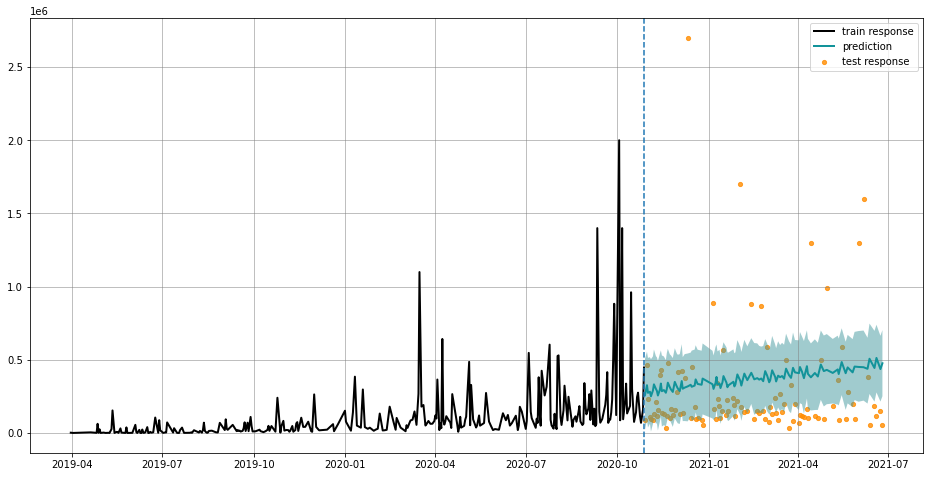

266010.301140382


In [ ]:
plot_predicted_data(
    training_actual_df=train_df, predicted_df=pred,
    date_col='ds', actual_col='y',
    test_actual_df=test_df,
    insample_line=True
)
print(mean_absolute_error(pred['prediction'], test_df['y']))

In [ ]:
train_df

,ds,y,count,shares,comments,plays
0,2019-03-31,3449.0,1,100.0,75.0,46900.0
1,2019-04-01,3012.0,1,56.0,28.0,41300.0
2,2019-04-02,1797.0,1,31.0,14.0,33400.0
3,2019-04-20,5772.0,1,387.0,22.0,56300.0
4,2019-04-26,2423.0,1,26.0,13.0,37400.0
...,...,...,...,...,...,...
310,2020-10-22,276800.0,1,4326.0,1706.0,1000000.0
311,2020-10-24,115600.0,1,1525.0,650.0,562200.0
312,2020-10-25,70800.0,1,911.0,354.0,390200.0
313,2020-10-27,159200.0,1,6892.0,3844.0,662500.0


In [ ]:
pd.Timedelta(days=1)

Timedelta('1 days 00:00:00')

In [ ]:
train_df.iloc[-1]['ds'] + datetime.timedelta(days=1)

datetime.date(2020, 10, 29)

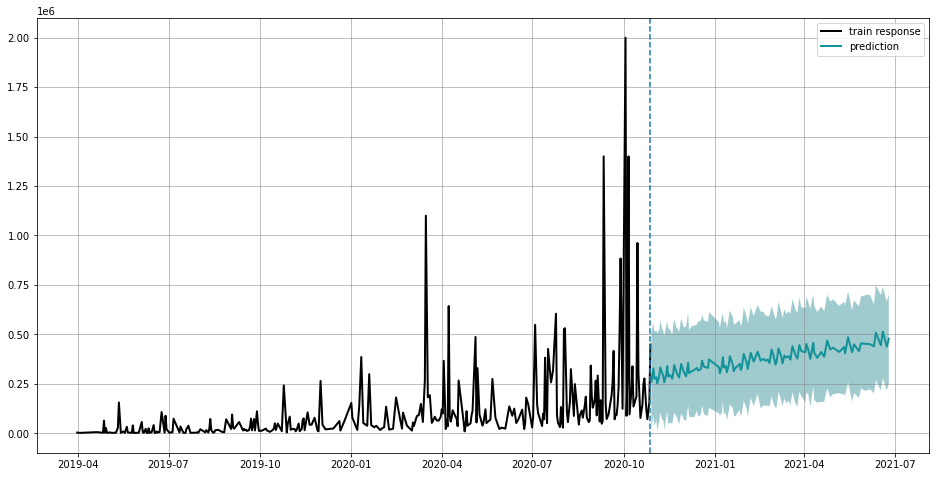

<AxesSubplot:>

In [ ]:
plot_predicted_data(
    training_actual_df=train_df, predicted_df=pred,
    date_col='ds', actual_col='y',
    insample_line=True
)

In [ ]:
pred_values = pred['prediction']

In [ ]:
pred_values.index = pd.Int64Index(pred_values.index)
pred_values.index += len(train_df)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='y'>)

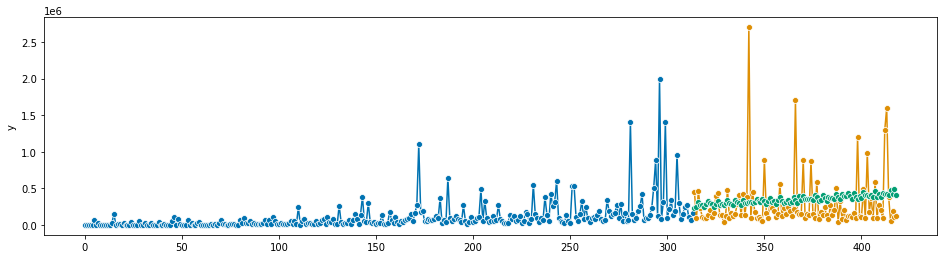

In [ ]:
plot_series(train_df['y'], test_df['y'], pred_values)